### New
Instead of using CAMB to compute the distance modulus, I directly integrate the Hubble function.

In [1]:
import sys
sys.path.append("../")
import platform
import os
import pandas as pd
import numpy as np
import math as m
import emcee
import corner
import matplotlib.pyplot as plt
import camb
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
# Import pyACC logger
from pyACC.helpers import Logger

# Set the logger
print = Logger("pyACC.CosmologicalDistances")

# Import integration class
from pyACC.Cosmology.distances import Dc, Dc_w0wa, Dc_w

### Why Direct Substitution is Incorrect

Inserting $w(z) = w_0 + w_a \frac{z}{1+z}$ directly into the Hubble parameter expression without proper integration will not capture the correct evolution of dark energy. The correct approach requires integrating the varying equation of state to accurately reflect its impact on the dark energy density.

#### Derivation with Variable $w(z)$

For a time-varying $w(z)$, the dark energy density evolves as:

$$
\rho_\Lambda(z) = \rho_{\Lambda 0} \exp \left( 3 \int_0^z \frac{1 + w(z')}{1 + z'} \, dz' \right)
$$

Given $w(z) = w_0 + w_a \frac{z}{1+z}$, the integral becomes:

$$
\int_0^z \frac{1 + w(z')}{1 + z'} \, dz' = \int_0^z \frac{1 + w_0 + w_a \frac{z'}{1 + z'}}{1 + z'} \, dz'
$$

Evaluating this integral:

$$
\int_0^z \frac{1 + w_0 + w_a \frac{z'}{1 + z'}}{1 + z'} \, dz' = (1 + w_0) \ln(1 + z) + w_a \frac{z}{1 + z}
$$

Thus, the dark energy density can be written as:

$$
\rho_\Lambda(z) = \rho_{\Lambda 0} (1+z)^{3(1+w_0)} \exp \left( 3 w_a \frac{z}{1+z} \right)
$$

#### Correct Expression for $H(z)$

Incorporating this into the Hubble parameter, we get:

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_r (1+z)^4 + \Omega_\Lambda (1+z)^{3(1+w_0)} \exp \left( 3 w_a \frac{z}{1+z} \right)}
$$

For a flat universe ($\Omega_k = 0$), where $\Omega_\Lambda = 1 - \Omega_m - \Omega_r$, this simplifies to:

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_r (1+z)^4 + (1 - \Omega_m - \Omega_r) (1+z)^{3(1+w_0)} \exp \left( 3 w_a \frac{z}{1+z} \right)}
$$

#### Why Direct Substitution is Incorrect

Directly substituting $w = w_0 + w_a (1 - a)$ into:

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_r (1+z)^4 + (1 - \Omega_m - \Omega_r) (1+z)^{3(1+w)}}
$$

would give:

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_r (1+z)^4 + (1 - \Omega_m - \Omega_r) (1+z)^{3(1+w_0 + w_a (1 - a))}}
$$

This approach ignores the integral needed to correctly account for the varying $w(z)$ over time. The exponential factor $\exp \left( 3 w_a \frac{z}{1+z} \right)$ from proper integration is crucial for accurately describing the effects of the time-varying equation of state.


The Hubble parameter $ H(z) $ for the $w_0 w_a$ CDM model is given by:

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_k (1+z)^2 + \Omega_{\Lambda} \exp\left[ 3 \int_0^z \frac{w(z')}{1+z'} \, dz' \right]}
$$

where the dark energy equation of state $ w(z) $ is:

$$
w(z) = w_0 + w_a \frac{z}{1+z}
$$

and

$$
3 \int_0^z \frac{w(z')}{1+z'} \, dz' = 3 \left[ w_0 \ln(1+z) - w_a \frac{z}{1+z} \right]
$$

Thus, the Hubble parameter becomes:

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_k (1+z)^2 + \Omega_{\Lambda} (1+z)^{3(1+w_0 + w_a)} \exp \left(-3 w_a \frac{z}{1+z} \right)}
$$

$\rightarrow$

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_r (1+z)^4 + (1-\Omega_{m}-\Omega_{r}) (1+z)^{3(1+w_0 + w_a)} \exp \left(-3 w_a \frac{z}{1+z} \right)}
$$

In [2]:
# Definition of the Hubble function and set the cosmology
def hubble_function_w0wa(z, Omega_m, Omega_r, Omega_k, Omega_lambda, w0, wa, H0):
    # Calculate the dark energy contribution
    dark_energy_contribution = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    
    # Calculate H(z)
    Hz = H0 * np.sqrt(
        Omega_m * (1 + z)**3 +
        Omega_r * (1 + z)**4 +
        Omega_k * (1 + z)**2 +
        Omega_lambda * dark_energy_contribution
    )
    
    return Hz


### File

In [3]:
file_path = 'lcparam_z_low.txt' #'lcparam_full_long.txt' #'lcparam_z_low.txt', 'lcparam_z_high.txt', binned_data.txt

with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

z_data = data['zcmb'].values
mb = data['mb'].values #B-band peak magnitude
dmb = data['dmb'].values

Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

### Relationship Between Hubble Function and Distance Modulus

1. **Luminosity Distance $d_L(z)$**

   The luminosity distance $d_L(z)$ is given by:

   $$
   d_L(z) = (1+z) \int_0^z \frac{dz'}{H(z')}.
   $$

   For the Hubble parameter $H(z)$ in the $w_0w_a$ CDM model:

   $$
   H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_r (1+z)^4 + (1 - \Omega_m - \Omega_r) (1+z)^{3(w_0 + w_a)} \exp\left(-3 w_a \frac{z}{1+z}\right)},
   $$

   you can plug this into the integral to find $d_L(z)$.

2. **Distance Modulus $\mu(z)$**

   The distance modulus $\mu(z)$ is given by:

   $$
   \mu(z) = 5 \log_{10}(d_L(z)) + 25.
   $$

### Summary

- **Compute the Luminosity Distance:**
  
  Integrate the inverse of $H(z)$:

  $$
  d_L(z) = (1+z) \int_0^z \frac{dz'}{H(z')}.
  $$

- **Compute the Distance Modulus:**
  
  Once $d_L(z)$ is computed, use:

  $$
  \mu(z) = 5 \log_{10}(d_L(z)) + 25.
  $$

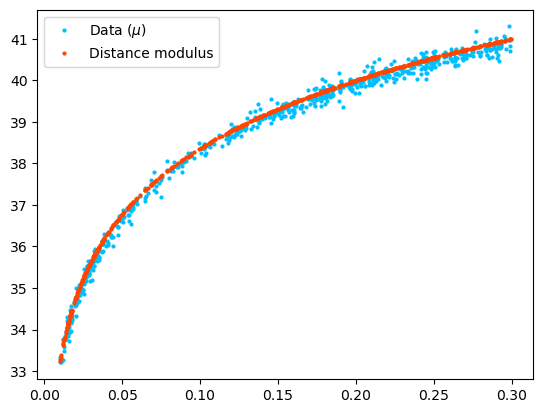

In [4]:
def get_mu(z, Omega_m, Omega_r, Omega_k, Omega_L, w0, wa, H0):
    mu = []
    for z_prime in z:
        mu.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_m, Omega_r, Omega_k, Omega_L, w0, wa, H0)*(1+z_prime)) + 25)
    return mu

#distance modulus of the data: mu_data=mb-M with M the absolute magnitude of a type Ia supernova, so M=-19.3
M=-19.3
mu_data=mb-M

plt.plot(z_data,mu_data,'o',markersize=2,color='deepskyblue',label='Data ($\mu$)')
plt.plot(z_data,get_mu(z_data, 0.319, 0, 0, 0.7, -1, 0, 68),'o',markersize=2,color='orangered',label='Distance modulus')
plt.legend()
plt.show()


### Prior

In [5]:
def log_prior(params):
    H0, Omega_m, Omega_r, w0, wa = params
    if 0 < H0 < 100 or 0 < Omega_m < 1 or -1e-3 < Omega_r < 1 or -2 < w0 < 0 or -2 < wa < 2:
        return 0
    '''
    if 0 < H0 < 100:
        print('H0')
        return 0
    if 0 < Omega_m < 1:
        print('Omega_m')
        return 0
    if 0 < Omega_r < 1:
        print('Omega_r')
        return 0
    if -3 < w0 < 0:
        print('w0')
        return 0
    if -3 < wa < 3:
        print('wa')
        return 0
    '''
    return -np.inf

### Likelihood

In [6]:
def log_likelihood(params,z,d,cov_inv):
    H0,Omega_m,Omega_r,w0,wa=params
    '''
    if not 65<H0<75:
        print(f"H0 out of bounds: {H0}")
        return -np.inf
    '''
    #'''
    if Omega_m<0:
        #print(f"Omega_m out of bounds: {Omega_m}")
        return -np.inf
    if Omega_r<0:
        #print(f"Omega_r out of bounds: {Omega_r}")
        return -np.inf
    #'''
    '''
    if not -2<w0<0:
        print(f"w0 out of bounds: {w0}")
        return -np.inf
    if not -2<wa<2:
        print(f"wa out of bounds: {wa}")
        return -np.inf
    '''
    mu=get_mu(z, Omega_m, Omega_r, 0, 0.7, w0, wa, H0)
    diff=d-mu
    #return -0.5 * diff @ cov_inv @ diff
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    #return term1 + term2
    if np.any(np.isnan(params)):
        return -np.inf
    if len(z)==len(z_data):
        return term1+term2
    else:
        return term1

### Posterior

In [7]:
def log_posterior(params,z,d,cov_inv):
    prior = log_prior(params)
    #check for NaNs
    if any(np.isnan(params)):
        print(f"NaNs in params: {params}")
    if np.isnan(prior):
        print(f"NaN in prior: {prior}")
    if np.isnan(log_likelihood(params,z,d,cov_inv)):
        print(f"NaN in likelihood: {log_likelihood(params,z,d,cov_inv)}")
        return prior
    if np.isfinite(prior):
        return prior + log_likelihood(params,z,d,cov_inv)
    return prior

### $\chi^2$

In [8]:
def chi(params,z,d,cov_inv):
    return -2*log_posterior(params,z,d,cov_inv)

### Parameter Optimization

In [9]:
'''
initial_guess = [68, 0.319, 0, -1, 0]

#result = minimize(lambda params: -log_likelihood(params,z_data,mu_data,Sigma_inv), initial_guess, method='Powell')
result = minimize(chi, initial_guess, args=(z_data, mu_data, Sigma_inv), method='Powell')
best_fit_params = result.x
#print(f"Best fit parameters: H0 = {optimized_params[0]}, Omega_matter = {optimized_params[1]}, Omega_rad = {optimized_params[2]}, w0 = {optimized_params[3]}, wa = {optimized_params[4]}") #, Omega_k = {optimized_params[3]}, Omega_L = {optimized_params[4]}

H0_best, Omega_matter_best, Omega_rad_best, w0_best, wa_best = best_fit_params
mu_model_best = []
#for z_prime in z_data:
    #mu_model_best.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_matter_best, Omega_rad_best, 0, 0.7, w0_best, wa_best, H0_best)*(1+z_prime)) + 25)
mu_model_best = get_mu(z_data, Omega_matter_best, Omega_rad_best, 0, 0.7, w0_best, wa_best, H0_best)
'''

'\ninitial_guess = [68, 0.319, 0, -1, 0]\n\n#result = minimize(lambda params: -log_likelihood(params,z_data,mu_data,Sigma_inv), initial_guess, method=\'Powell\')\nresult = minimize(chi, initial_guess, args=(z_data, mu_data, Sigma_inv), method=\'Powell\')\nbest_fit_params = result.x\n#print(f"Best fit parameters: H0 = {optimized_params[0]}, Omega_matter = {optimized_params[1]}, Omega_rad = {optimized_params[2]}, w0 = {optimized_params[3]}, wa = {optimized_params[4]}") #, Omega_k = {optimized_params[3]}, Omega_L = {optimized_params[4]}\n\nH0_best, Omega_matter_best, Omega_rad_best, w0_best, wa_best = best_fit_params\nmu_model_best = []\n#for z_prime in z_data:\n    #mu_model_best.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_matter_best, Omega_rad_best, 0, 0.7, w0_best, wa_best, H0_best)*(1+z_prime)) + 25)\nmu_model_best = get_mu(z_data, Omega_matter_best, Omega_rad_best, 0, 0.7, w0_best, wa_best, H0_best)\n'

In [10]:
'''
plt.errorbar(z_data, mu_data, yerr=dmb, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data, mu_model_best, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

residuals = mu_data - mu_model_best
plt.errorbar(z_data, residuals, yerr=dmb, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

print("--------------------------------------")
print("Best-fit parameters:")
print("H0:", best_fit_params[0])
print("Omega_m:", best_fit_params[1])
print("Omega_r:", best_fit_params[2])
print("w0:", best_fit_params[3])
print("wa:", best_fit_params[4])
print("--------------------------------------")
chi2 = -2 * log_posterior(best_fit_params, z_data, mu_data, Sigma_inv)
print("Chi-square:", chi2)
print("Degrees of freedom:", len(z_data) - len(best_fit_params))
print("Reduced chi-square:", chi2 / (len(z_data) - len(best_fit_params)))
print("--------------------------------------")
'''

'\nplt.errorbar(z_data, mu_data, yerr=dmb, fmt=\'o\', markersize=1, color=\'deepskyblue\', label=\'Data ($\\mu$)\')\nplt.plot(z_data, mu_model_best, \'o\', markersize=1, color=\'orangered\', label=\'Best-fit model ($\\mu$)\')\nplt.xlabel(\'Redshift (z)\')\nplt.ylabel(\'Distance Modulus ($\\mu$)\')\nplt.legend()\nplt.show()\n\nresiduals = mu_data - mu_model_best\nplt.errorbar(z_data, residuals, yerr=dmb, fmt=\'o\', markersize=2, color=\'deepskyblue\')\nplt.axhline(0, color=\'gray\', linestyle=\'--\')\nplt.xlabel(\'Redshift (z)\')\nplt.ylabel(\'Residuals ($\\mu_{\text{data}} - \\mu_{\text{model}}$)\')\nplt.show()\n\nprint("--------------------------------------")\nprint("Best-fit parameters:")\nprint("H0:", best_fit_params[0])\nprint("Omega_m:", best_fit_params[1])\nprint("Omega_r:", best_fit_params[2])\nprint("w0:", best_fit_params[3])\nprint("wa:", best_fit_params[4])\nprint("--------------------------------------")\nchi2 = -2 * log_posterior(best_fit_params, z_data, mu_data, Sigma_inv

## MCMC

In [11]:
# Initialize the MCMC sampler
initial = np.array([68, 0.319, 0, -1, 0])
ndim = len(initial)
nwalkers = 10
#pos = initial + 1e-1 * np.random.randn(nwalkers, ndim)

# Separate standard deviations for different parameter groups
std_H0_Om0_Omr = 1e-2
std_w0_wa = 1e-2

# Create the initial positions with different standard deviations
pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_H0_Om0_Omr * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_H0_Om0_Omr * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_H0_Om0_Omr * np.random.randn(nwalkers)
pos[:, 3] = initial[3] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 4] = initial[4] + std_w0_wa * np.random.randn(nwalkers)


#'''
# Check initial likelihoods
for i in range(nwalkers):
    print(log_likelihood(pos[i], z_data, mu_data, Sigma_inv))

# Check initial posteriors
for i in range(nwalkers):
    print(log_posterior(pos[i], z_data, mu_data, Sigma_inv))
#'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data, mu_data, Sigma_inv))

2024-07-28 13:25:54.827108 :: pyACC.CosmologicalDistances  :: -322.0955447838419
2024-07-28 13:25:54.827467 :: pyACC.CosmologicalDistances  :: -inf
2024-07-28 13:25:57.221596 :: pyACC.CosmologicalDistances  :: -321.6974467617641
2024-07-28 13:25:57.221852 :: pyACC.CosmologicalDistances  :: -inf
2024-07-28 13:25:57.221945 :: pyACC.CosmologicalDistances  :: -inf
2024-07-28 13:25:57.222068 :: pyACC.CosmologicalDistances  :: -inf
2024-07-28 13:25:59.673250 :: pyACC.CosmologicalDistances  :: -322.0035119718244
2024-07-28 13:26:02.265026 :: pyACC.CosmologicalDistances  :: -322.0212062321106
2024-07-28 13:26:02.265298 :: pyACC.CosmologicalDistances  :: -inf
2024-07-28 13:26:04.912290 :: pyACC.CosmologicalDistances  :: -322.1108247935375
2024-07-28 13:26:09.921198 :: pyACC.CosmologicalDistances  :: -322.0955447838419
2024-07-28 13:26:09.921488 :: pyACC.CosmologicalDistances  :: -inf
2024-07-28 13:26:15.097884 :: pyACC.CosmologicalDistances  :: -321.6974467617641
2024-07-28 13:26:15.098166 :: p

In [12]:
# Run the MCMC sampler
nsteps = 200
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=30,thin=10,flat=True)

  0%|          | 0/200 [00:00<?, ?it/s]/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [1:53:12<00:00, 33.96s/it]  


### Plot

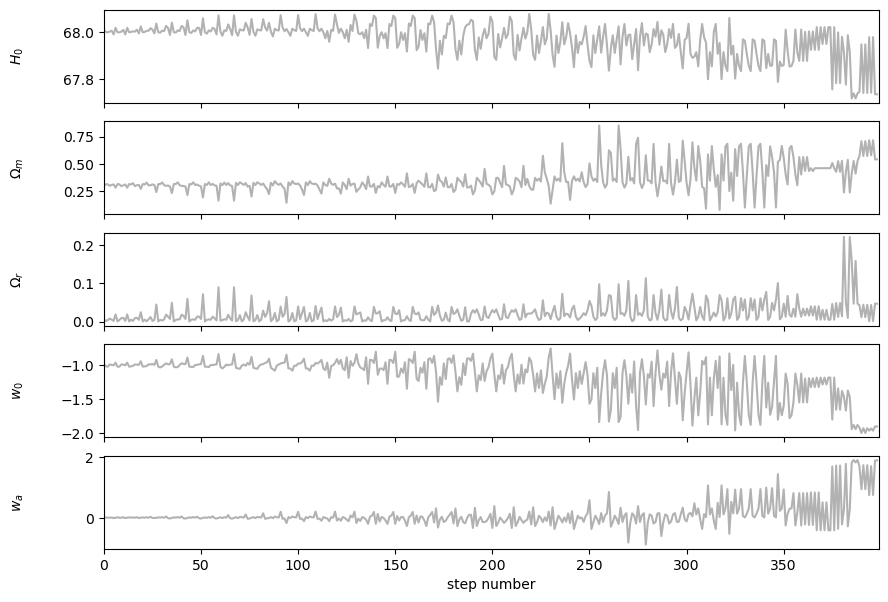

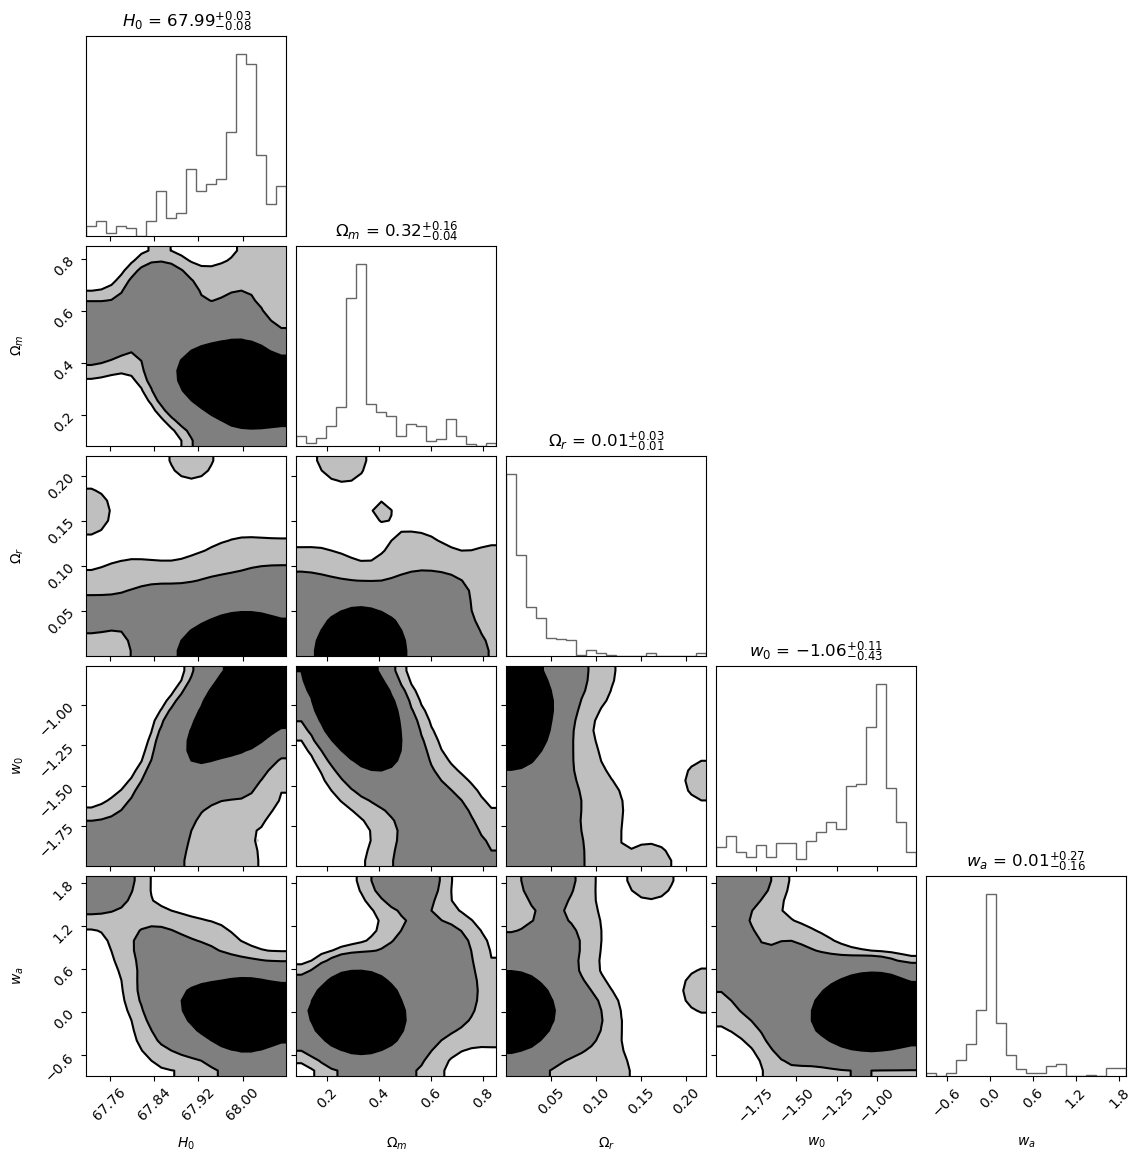

In [17]:
reshaped_samples = samples.reshape(-1, samples.shape[-1])

#i want to delete all H0 <0 and H0>80
reshaped_samples = reshaped_samples[(reshaped_samples[:,0]>0) & (reshaped_samples[:,0]<80)]

#i want to delete all Omega_m <0 and Omega_m>0.7
reshaped_samples = reshaped_samples[(reshaped_samples[:,1]>0) & (reshaped_samples[:,1]<1)]

#i want to delete all Omega_r <0 and Omega_r>0.1
reshaped_samples = reshaped_samples[(reshaped_samples[:,2]>0) & (reshaped_samples[:,2]<1)]

#i want to delete all w0 <-2 and w0>0
reshaped_samples = reshaped_samples[(reshaped_samples[:,3]>-2) & (reshaped_samples[:,3]<0)]

#i want to delete all wa <-2 and wa>2
reshaped_samples = reshaped_samples[(reshaped_samples[:,4]>-2) & (reshaped_samples[:,4]<2)]

#plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$H_0$", "$\Omega_m$", "$\Omega_r$", "$w_0$", "$w_a$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(reshaped_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(reshaped_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

#plot the corner plot
#fig = corner.corner(reshaped_samples, labels=labels, smooth=2.0, levels=[0.68, 0.95]) #, truths=best_fit_params
#plt.show()
# Plot the corner plot with enhanced aesthetics
fig = corner.corner(reshaped_samples, labels=labels, smooth = 2.0,
                    plot_contours=True, 
                    fill_contours=True, 
                    levels=(0.68, 0.95, 0.99),
                    #contour_kwargs={"colors": ["blue", "orange", "green"], "alpha": 0.75},
                    show_titles=True, # Show the titles (mean and std)
                    title_fmt=".2f", # Format the title to 2 decimal places
                    title_kwargs={"fontsize": 12},
                    hist_kwargs={"density": True, "alpha": 0.6})

2024-07-28 15:20:08.260505 :: pyACC.CosmologicalDistances  :: Mean values of H0: 67.91152223615633 ± 0.07993391632993388
2024-07-28 15:20:08.261237 :: pyACC.CosmologicalDistances  :: Mean values of Omega_matter: 0.49639568479902046 ± 0.17859278697603367
2024-07-28 15:20:08.261316 :: pyACC.CosmologicalDistances  :: Mean values of Omega_rad: 0.028461066919224343 ± 0.020710457614462142
2024-07-28 15:20:08.261383 :: pyACC.CosmologicalDistances  :: Mean values of w0: -1.4843734828240187 ± 0.37667537944854196
2024-07-28 15:20:08.261446 :: pyACC.CosmologicalDistances  :: Mean values of wa: 0.464954574005126 ± 0.5996468842535307


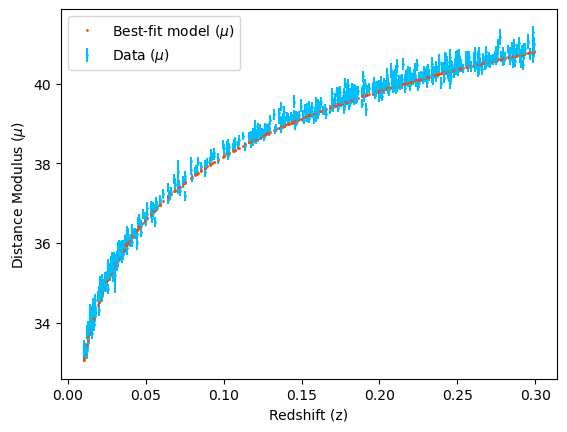

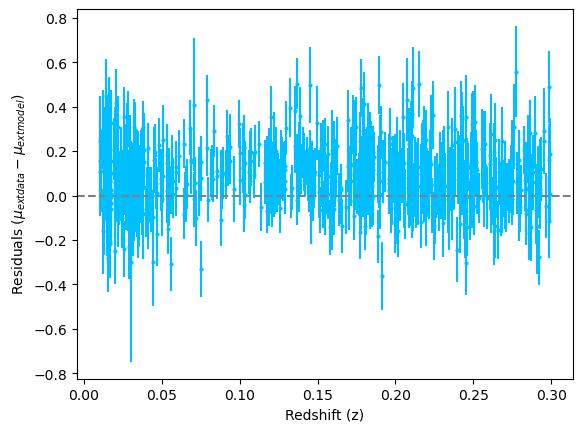

In [14]:
#plot the best fit model
best_fit_params_mcmc = np.mean(reshaped_samples, axis=0)
std_devs = np.std(reshaped_samples, axis=0)
#Print the results for each parameters
print("Mean values of H0:", best_fit_params_mcmc[0], "±", std_devs[0])
print("Mean values of Omega_matter:", best_fit_params_mcmc[1], "±", std_devs[1])
print("Mean values of Omega_rad:", best_fit_params_mcmc[2], "±", std_devs[2])
print("Mean values of w0:", best_fit_params_mcmc[3], "±", std_devs[3])
print("Mean values of wa:", best_fit_params_mcmc[4], "±", std_devs[4])

mu_model_best_mcmc = get_mu(z_data, best_fit_params_mcmc[1], best_fit_params_mcmc[2], 0, 0.7, best_fit_params_mcmc[3], best_fit_params_mcmc[4], best_fit_params_mcmc[0])

plt.errorbar(z_data, mu_data, yerr=dmb, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data, mu_model_best_mcmc, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

#plot the residuals
residuals_mcmc = mu_data - mu_model_best_mcmc
plt.errorbar(z_data, residuals_mcmc, yerr=dmb, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()